In [1]:
import numpy as np
import glob2
import datetime
from pathlib import Path
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.sound_model.spherical_sound_model import HomogeneousSphericalSoundModel as HomogeneousSoundModel

from utils.detection.association import compute_candidates, association_is_new, update_valid_grid, update_results

/home/plerolland/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
det_dir = "../../../data/detection/TiSSNet/OHASISBIO-2018"
catalog_path = "/home/plerolland/Bureau/dataset.yaml"
out_dir = "../../../data/detection/association/OHASISBIO_grid.csv"

YEAR = 2018
STATIONS = StationsCatalog(catalog_path).filter_out_undated().filter_out_unlocated().ends_after(datetime.datetime(YEAR,1,1)).starts_before(datetime.datetime(YEAR,12,31))
SOUND_MODEL = HomogeneousSoundModel(sound_speed=1485.5)

MIN_P_TISSNET_PRIMARY = 0.5  # min probability of browsed detections
MIN_P_TISSNET_SECONDARY = 0.1  # min probability of detections that can be associated with the browsed one

In [3]:
LAT_BOUNDS = [-60, -15]
LON_BOUNDS = [40, 90]
GRID_SIZE = 300
PTS_LAT = np.linspace(LAT_BOUNDS[0], LAT_BOUNDS[1], GRID_SIZE)
PTS_LON = np.linspace(LON_BOUNDS[0], LON_BOUNDS[1], GRID_SIZE)

SOUND_SPEED_UNCERTAINTY = 2
GRID_MAX_RES_TIME = (np.sqrt(2) * (PTS_LAT[1]-PTS_LAT[0]) * 111_000) / (SOUND_MODEL.sound_speed - SOUND_SPEED_UNCERTAINTY)
PICK_UNCERTAINTY = 5
GENERIC_TOLERANCE = 10
GRID_TOLERANCE = GRID_MAX_RES_TIME + PICK_UNCERTAINTY
print(f"Grid tolerance of {GRID_TOLERANCE:.2f}s")

GRID_STATION_TRAVEL_TIME = {s : np.zeros((len(PTS_LAT), len(PTS_LON))) for s in STATIONS}
for s in tqdm(STATIONS, desc="computing travel time grid"):
    for ilat, lat in enumerate(PTS_LAT):
        for ilon, lon in enumerate(PTS_LON):
            GRID_STATION_TRAVEL_TIME[s][ilat, ilon] = SOUND_MODEL.get_sound_travel_time([lat, lon], s.get_pos())

GRID_STATION_COUPLE_TRAVEL_TIME = {s : {s2 : np.zeros((len(PTS_LAT), len(PTS_LON))) for s2 in STATIONS} for s in STATIONS}
for s in STATIONS:
    for s2 in STATIONS:
        GRID_STATION_COUPLE_TRAVEL_TIME[s][s2] = GRID_STATION_TRAVEL_TIME[s2] - GRID_STATION_TRAVEL_TIME[s]

STATION_MAX_TRAVEL_TIME = {s : {s2 : SOUND_MODEL.get_sound_travel_time(s.get_pos(), s2.get_pos()) for s2 in STATIONS} for s in STATIONS}

Grid tolerance of 20.93s


computing travel time grid: 100%|██████████| 19/19 [00:27<00:00,  1.44s/it]
/home/plerolland/Bureau/toolbox/src/utils/physics/sound_model/spherical_sound_model.py:62: RuntimeWarning: invalid value encountered in arccos
  delta_sigma = np.arccos(arc)


In [4]:
MERGE_DELTA = datetime.timedelta(seconds=5)  # threshold below which we consider two events should be merged
DETECTIONS = {}

for det_file in tqdm(glob2.glob(det_dir + "/*")):
    d = []
    with open(det_file, "rb") as f:
        while True:
            try:
                d.append(pickle.load(f))
            except EOFError:
                break
    d = np.array(d)
    d = d[:,:2]
    d = d[d[:,1] > MIN_P_TISSNET_SECONDARY]
    d = d[np.argsort(d[:,0])]

    # remove duplicates and regularly spaced signals
    new_d = [d[0]]
    for i in range(1, len(d)):
        # check this event is far enough from the previous one
        if d[i,0] - d[i-1,0] > MERGE_DELTA:
            # check this event is not part of a series of regularly spaced events (which probably means we encounter seismic airgun shots)
            if i < 3 or abs((d[i,0]-d[i-1,0]) - (d[i-1,0]-d[i-2,0])) > MERGE_DELTA and abs((d[i,0]-d[i-2,0]) - (d[i-1,0]-d[i-3,0])) > MERGE_DELTA:
                new_d.append(d[i])
    d = np.array(new_d)

    s_name = det_file[:-2].split("/")[-1].split("_")[-1]
    s_name, y_start = ID, sname = "-".join(s_name.split("-")[:-1]), s_name.split("-")[-1]

    station = STATIONS.by_name(s_name).by_starting_year(int(y_start))[0]
    DETECTIONS[station] = d

    print(f"Found {len(d)} detections for station {s_name}")

# we keep all detections in a single list, sorted by date, to then browse detections
DETECTIONS_MERGED = np.concatenate([[(det[0], det[1], s) for det in DETECTIONS[s]] for s in STATIONS])
DETECTIONS_MERGED = DETECTIONS_MERGED[DETECTIONS_MERGED[:,1] > MIN_P_TISSNET_PRIMARY]
DETECTIONS_MERGED = DETECTIONS_MERGED[np.argsort(DETECTIONS_MERGED[:,0])]

np.save("detections.npy", DETECTIONS)
np.save("detections_merged.npy", DETECTIONS_MERGED)

  5%|▌         | 1/19 [00:03<01:08,  3.79s/it]

Found 101425 detections for station RTJ


 11%|█         | 2/19 [00:07<01:06,  3.92s/it]

Found 108490 detections for station ELAN


 16%|█▌        | 3/19 [00:08<00:40,  2.56s/it]

Found 25776 detections for station MADE


 21%|██        | 4/19 [00:11<00:38,  2.54s/it]

Found 71753 detections for station MADE
Found 331 detections for station MADW


 32%|███▏      | 6/19 [00:15<00:30,  2.34s/it]

Found 110097 detections for station MADW


 37%|███▋      | 7/19 [00:24<00:50,  4.25s/it]

Found 232246 detections for station H01W1


 42%|████▏     | 8/19 [00:34<01:04,  5.85s/it]

Found 270649 detections for station H04N1


 47%|████▋     | 9/19 [00:48<01:21,  8.11s/it]

Found 373135 detections for station H04S1


 53%|█████▎    | 10/19 [00:51<00:58,  6.51s/it]

Found 62548 detections for station H08S1


 58%|█████▊    | 11/19 [00:51<00:38,  4.83s/it]

Found 23597 detections for station NEAMS


 63%|██████▎   | 12/19 [00:58<00:37,  5.39s/it]

Found 175290 detections for station NEAMS


 68%|██████▊   | 13/19 [00:59<00:23,  3.99s/it]

Found 20023 detections for station SSEIR


 74%|███████▎  | 14/19 [01:06<00:24,  4.81s/it]

Found 172938 detections for station SSEIR


 89%|████████▉ | 17/19 [01:11<00:05,  2.75s/it]

Found 121878 detections for station SSWIR
Found 272 detections for station SWAMS
Found 4176 detections for station WKER2


 95%|█████████▍| 18/19 [01:14<00:02,  2.65s/it]

Found 71462 detections for station WKER2


100%|██████████| 19/19 [01:19<00:00,  4.19s/it]

Found 167644 detections for station SWAMS-bot


In [4]:
DETECTIONS = np.load("detections.npy", allow_pickle=True).item()
DETECTIONS_MERGED = np.load("detections_merged.npy", allow_pickle=True)

In [24]:
associations = {}
association_hashlist = set()

print("starting association")

REQ_CLOSEST_STATIONS = 3  # The REQ_CLOSEST_STATIONS th closest stations will be required for an association to be valid

SAVE_PATH_ROOT = "../../../data/detection/association/grids/real_data"
SAVE_PATH_ROOT = None

# dets_merged : (n,3) = n_detections x (det_time, det_probability, station)
for date1, p1, s1 in tqdm(DETECTIONS_MERGED):
    # in case one wants to save the grids (for visual representation of the algorithm), update the path to have 1 directory per browsed date
    save_path = SAVE_PATH_ROOT
    if save_path is not None:
        save_path = f'{save_path}/{s1.name}-{date1.strftime("%Y%m%d_%H%M%S")}'
        Path(save_path).mkdir(parents=True, exist_ok=True)

    # list all other stations and sort them by distance from s1
    other_stations = np.array([s2 for s2 in STATIONS if s2 != s1])
    other_stations = other_stations[np.argsort([STATION_MAX_TRAVEL_TIME[s1][s2] for s2 in other_stations])]

    # given the detection date1 occurred on station s1, list all the detections of other stations that may be generated by the same source event
    current_association = {s1:date1}
    candidates =  compute_candidates(other_stations, current_association, DETECTIONS, STATION_MAX_TRAVEL_TIME, GENERIC_TOLERANCE)

    # update the list of other stations to only include the ones having at least a candidate detection
    other_stations = [s for s in other_stations if len(candidates[s]) > 0]

    # define the recursive browsing function (that is responsible for browsing the search space of associations for s1-date1)
    def backtrack(station_index, current_association, valid_grid, associations, save_path):
        if station_index == len(other_stations):
            return
        station = other_stations[station_index]

        candidates = compute_candidates([station], current_association, DETECTIONS, STATION_MAX_TRAVEL_TIME, GENERIC_TOLERANCE)
        for idx in candidates[station]:
            date, p = DETECTIONS[station][idx]
            if not association_is_new(current_association, date, association_hashlist):
                continue

            valid_grid_new, dg_new = update_valid_grid(current_association, valid_grid, station, date, GRID_STATION_COUPLE_TRAVEL_TIME, GRID_TOLERANCE, save_path, LON_BOUNDS, LAT_BOUNDS)

            valid_points_new = np.argwhere(valid_grid_new)

            if len(valid_points_new) > 0:
                current_association[station] = (date)

                update_results(date1, current_association, valid_points_new, associations, GRID_STATION_COUPLE_TRAVEL_TIME)

                backtrack(station_index + 1, current_association, valid_grid_new, associations, save_path)
                del current_association[station]
        # also try without self
        if station_index >= REQ_CLOSEST_STATIONS:
            backtrack(station_index + 1, current_association, valid_grid, associations, save_path)
        return
    backtrack(0, current_association, None, associations, save_path=save_path)

starting association


  0%|          | 172/166446 [00:36<9:45:32,  4.73it/s] 


KeyboardInterrupt: 

In [ ]:
from multiprocessing import cpu_count

cpus = cpu_count()
print(cpus)

print("starting association")

REQ_CLOSEST_STATIONS = 3  # The REQ_CLOSEST_STATIONS th closest stations will be required for an association to be valid

SAVE_PATH_ROOT = "../../../data/detection/association/grids"
SAVE_PATH_ROOT = None

# dets_merged : (n,3) = n_detections x (det_time, det_probability, station)
def process_detection(arg):
    detection, local_association_hashlist = arg
    local_associations = {}
    date1, p1, s1 = detection
    save_path = SAVE_PATH_ROOT
    if save_path is not None:
        save_path = f'{save_path}/{s1.name}-{date1.strftime("%Y%m%d_%H%M%S")}'
        Path(save_path).mkdir(parents=True, exist_ok=True)

    # list all other stations and sort them by distance from s1
    other_stations = np.array([s2 for s2 in STATIONS if s2 != s1])
    other_stations = other_stations[np.argsort([STATION_MAX_TRAVEL_TIME[s1][s2] for s2 in other_stations])]

    # given the detection date1 occurred on station s1, list all the detections of other stations that may be generated by the same source event
    current_association = {s1:date1}
    candidates =  compute_candidates(other_stations, current_association, DETECTIONS, STATION_MAX_TRAVEL_TIME, GENERIC_TOLERANCE)

    # update the list of other stations to only include the ones having at least a candidate detection
    other_stations = [s for s in other_stations if len(candidates[s]) > 0]

    # define the recursive browsing function (that is responsible for browsing the search space of associations for s1-date1)
    def backtrack(station_index, current_association, valid_grid, associations, save_path):
        if station_index == len(other_stations):
            return
        station = other_stations[station_index]

        candidates = compute_candidates([station], current_association, DETECTIONS, STATION_MAX_TRAVEL_TIME, GENERIC_TOLERANCE)
        for idx in candidates[station]:
            date, p = DETECTIONS[station][idx]
            if not association_is_new(current_association, date, local_association_hashlist):
                continue

            valid_grid_new, dg_new = update_valid_grid(current_association, valid_grid, station, date, GRID_STATION_COUPLE_TRAVEL_TIME, GRID_TOLERANCE, save_path, LON_BOUNDS, LAT_BOUNDS)

            valid_points_new = np.argwhere(valid_grid_new)

            if len(valid_points_new) > 0:
                current_association[station] = (date)

                update_results(date1, current_association, valid_points_new, local_associations, GRID_STATION_COUPLE_TRAVEL_TIME)

                backtrack(station_index + 1, current_association, valid_grid_new, associations, save_path)
                del current_association[station]
        # also try without self
        if station_index >= REQ_CLOSEST_STATIONS:
            backtrack(station_index + 1, current_association, valid_grid, associations, save_path)
        return
    backtrack(0, current_association, None, associations, save_path=save_path)
    return local_associations, local_association_hashlist

association_hashlist = set()
associations = {}

with ProcessPoolExecutor(cpu_count()-8) as executor:
    futures = {executor.submit(process_detection, (det, association_hashlist)): det for det in DETECTIONS_MERGED}
    for future in tqdm(as_completed(futures), total=len(futures)):
        local_association, local_association_hashlist = future.result()
        association_hashlist = association_hashlist.union(local_association_hashlist)
        associations = associations | local_association


28
starting association


  8%|▊         | 14008/166446 [8:02:04<397:55:00,  9.40s/it]

In [1]:
np.save("associations.npy", associations)

NameError: name 'np' is not defined

In [6]:
print(len(associations))

2574


In [7]:
valid = np.zeros((GRID_SIZE,GRID_SIZE))
for date, associations_ in associations.items():
    for (detections, valid_points) in associations_:
        if len(detections) < 5:
            continue
        for i, j in valid_points:
            valid[i,j] += 1

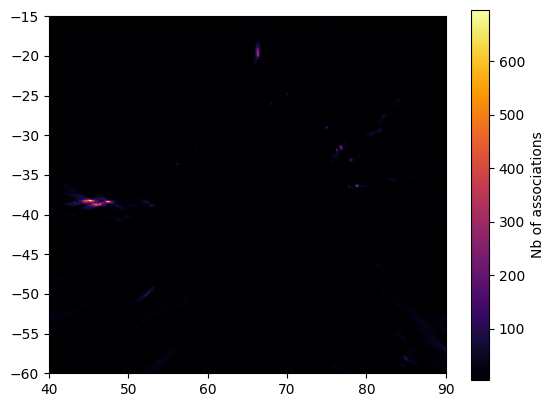

In [13]:
from matplotlib import pyplot as plt

extent = (LON_BOUNDS[0], LON_BOUNDS[-1], LAT_BOUNDS[0], LAT_BOUNDS[-1])
im = plt.imshow(valid[::-1], cmap="inferno", extent=extent, vmin=5, interpolation=None)
cbar = plt.colorbar(im)
cbar.set_label('Nb of associations')